Authors: 
This code builds an IKEA Index using webscrapping of various IKEA websites. This index is then compared with the Big Mac Index to proxy purchasing power in different countries. This code was build for a project in the "Introduction to Social Data Science" course at University of Copenhagen in 2020. 

Authors:  Pablo Serrano Ascandoni, 
          Marius Mundhenk, 
          Rasmus Juul Jørgensen, 
          Lasse Ramovic Laustrup

This jupyter notebook requires certain packages and modules. Those either have to be installed or if already installed activated. To not induce any long installation processes we are just going to list them in markup:
The required packages are:
pandas, BeautifulSoup, numpy, pycountry, ccy, selenium, Babel, time, requests, seaborn


In [1]:
## Packages needed:
# pandas, BeautifulSoup, numpy, pycountry, ccy
# to install:
!pip install pycountry
!pip install ccy
!pip install Babel
!pip install selenium
# to import:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import pycountry, ccy
import requests
import tqdm, time, os, re, itertools, scraping_class
# import geopandas
# We installed geopandas using HomeBrew, a package manager for MacOS. For windows a different package manager would be needed
#$ /bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install.sh)"
#$ brew install gdal
#$ brew install geos
#$ brew install spatialindex
#$ pip3 install pillow
#$ pip3 install pysal
#$ pip3 install geopandas
#$ pip3 install rtree
#!pip install geopandas
#!conda install -c conda-forge mapclassify
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
#
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from babel.core import get_global
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col


/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### DEFINE FUNCTIONS FOR LATER USE   

In [2]:
def ratelimit():
    "A function that handles the rate of your calls."
    time.sleep(0.5) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit()
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit()
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id
    
# Used in the scraping functions 
def is_int(val):
    if type(val) == int:
        return True
    else:
        if val.is_integer():
            return True
        else:
            return False

#### SCRAPPING A LIST OF COUNTRIES AND BUILD URLS AND COUNTRY CODES  

In [3]:
# Scraping a table from wikipedia
connector = Connector('log_wikipedia.csv')
url = 'https://en.wikipedia.org/wiki/List_of_countries_with_IKEA_stores'
response,call_id = connector.get(url,'wikipedia_list')
html = response.text
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup
tables = soup.find_all('table')
holding = []
countries = []
for table in tables:
    rows = table.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        if len(cells) > 2:
            holding_name = cells[0]
            holding.append(holding_name.text.strip())
            
            country = cells[2]
            countries.append(country.text.strip())
df_wikipedia = pd.DataFrame()
df_wikipedia['countries']=countries
df_wikipedia['holding']=holding
df_wikipedia=df_wikipedia[-11:] #select the table (all tables have the same identifiers) we want
df_wikipedia=df_wikipedia.reset_index(drop=True)

# Transform the DataFrame into one where there is just one country per row
# create a list of lists containing the countries splitting the strings containing multiple ones in the table by ','
countries_1=[] # lists (one for each row, containing the country names) in a list
for i in df_wikipedia['countries']:
    countries_1.append(i.split(','))

# create a flat list out of the list in list
flat_list = []
for sublist in countries_1:
    for item in sublist:
        flat_list.append(item.strip())
df_countries = pd.DataFrame(flat_list, columns =['country'])

# Add the Holdings back on
l = []
m = []
for i in df_countries['country']:
    for n,j in enumerate(df_wikipedia['countries']):
        if i in j:
            l.append(i)
        else:
            l.append(np.nan)
        m.append(df_wikipedia['holding'][n])

df_countries_clean = pd.DataFrame()
df_countries_clean['l'] = l
df_countries_clean['m'] = m
df_countries_clean=df_countries_clean.dropna()
# Here we do some manual cleaning up
df_countries_clean.at[102,'l'] = 'Indonesia' # from "Indonesia (as Hero Supermarket)"
df_countries_clean.at[237,'l'] = 'China' # from "China (Peoples Republic of)"
df_countries_clean.at[457,'l'] = 'Korea, Republic of' # from "South Korea"
df_countries_clean=df_countries_clean.drop(593) #Drop "Spanish Islands" since the subpages of the balearic islands and canary islands cant be accessed with our code
df_countries_clean=df_countries_clean.reset_index(drop=True)
countries_list=df_countries_clean['l'].to_list() # obtain a list of cleaned up countries for later use
list_holding=df_countries_clean['m'].to_list() # obtain a list of all the holdings for later use

### Take the list of countries scraped from Wikipedia and build a DataFrame containing relevant information 


In [4]:
## Take the list of countries scraped from Wikipedia and build a DataFrame containing relevant information 
# Clean up country names with pycoutry to identify the country code
def create_country_codes(countries_list):
    country_codes=[] #container for the 2 digit country codes in small letters e.g. 'dk'
    country_codes_alpha_3=[] #container for the 3 digit country codes e.g. 'DNK'
    country_list_clean=[] # Container for the cleaned up country names e.g. 'Czechia' instead of 'Czech Republic'
    for country in countries_list: #loop through the list of input countries
        temp=[] #temporal container
        temp.append(pycountry.countries.search_fuzzy(f'{country}')) #store the potential fuzzy search results for all countries in the temporary container
        for i in temp: #loop thought the fuzzy search results countries
            for j in i: #loop through the country results
                if j==i[0]: #choose the first option, which is the best fit in all cases so far
                    country_codes.append(j.alpha_2.lower()) 
                    country_codes_alpha_3.append(j.alpha_3)
                    country_list_clean.append(j.name)
    return country_codes, country_codes_alpha_3, country_list_clean

# Obtain currency codes for each country
def create_currency_codes(country_codes):
    currency_codes=[]
    for i in country_codes:
        currency_codes.append(ccy.countryccy(i))
    return currency_codes

# Obtain the language codes from country codes
def create_language_codes(country_codes):
#     Obtain language codes for all official languages in a country
        def get_official_languages(territory, regional=False, de_facto=True): 
            territory = str(territory).upper()
            allowed_stati = {"official"}
            if regional:
                allowed_stati.add("official_regional")
            if de_facto:
                allowed_stati.add("de_facto_official")

            languages = get_global("territory_languages").get(territory, {})
            pairs = [
                (info['population_percent'], language)
                for language, info in languages.items()
                if info.get('official_status') in allowed_stati
            ]
            pairs.sort(reverse=True)
            return tuple(lang for _, lang in pairs)

        language_tupels=[]
        for i in country_codes:
            language_tupels.append(get_official_languages(i)[:1])    # get the most common, the first one
        language_codes=[item[:2] for t in language_tupels for item in t] # get 2-letter language codes for use
        return language_codes
    
# Use the functions defined above to obtain a DataFrame
def list_to_df_IKEA (countries_list):
#     Call on the function that creates country codes and clear names from a list of countries
    country_codes, country_codes_alpha_3, country_list_clean = create_country_codes(countries_list) 
    
#     Call on the function that obtaines the currency codes from the country codes
    currency_codes=create_currency_codes(country_codes)
    
#     Call on the function that obtains language codes from country codes
    language_codes=create_language_codes(country_codes)
    
#     Construct URLs by testing different options (made out of counrty and language codes) and saving the ones that work
    def request_country(country_codes, language_codes):
        response_url=[]
        countries_url=[]
        base_url='https://www.ikea.com'
        for i, j in zip(country_codes, language_codes):
            url=base_url+f'/{i}'+f'/{j}'
            r=requests.get(url)
            if r.status_code==404:
                url=base_url+f'/{i}'+f'/{i}' # e.g. ikea.com/no/no for Norway
                r=requests.get(url)
                if r.status_code==404:
                    url='https://www.ikea.com'+f'/{i}'+'/en'
                    r=requests.get(url)
                    if r.status_code==404:
                        url='https://www.ikea.com'+f'.{i}' #e.g. ikea.com.cy cyprus
                        try:
                            r=requests.get(url)
                        except:
                            r.status_code = "Connection refused"
                        if r.status_code=="Connection refused":
                            url='https://www.ikea'+f'.{i}' #e.g. ikea.is Iceland
                            try:
                                r=requests.get(url)
                            except:
                                r.status_code = "Connection refused"
            response_url.append(r)
            countries_url.append(url)
            time.sleep(0.5) 
        return countries_url, response_url
    countries_url, response_url=request_country(country_codes, language_codes)
    
    #Create a DataFrame containg all the information needed 
    def create_df_IKEA(countries_list,country_list_clean,country_codes,country_codes_alpha_3,language_codes,
                       currency_codes,countries_url,list_holding):
        df_IKEA=pd.DataFrame()
        df_IKEA['Countries']=countries_list
        df_IKEA['Countries']=country_list_clean
        df_IKEA['ISO-3166-Alpha_2']=country_codes
        df_IKEA['ISO-3166-Alpha_3']=country_codes_alpha_3
        df_IKEA['ISO-639-1']=language_codes
        df_IKEA['ISO-4217']=currency_codes
        df_IKEA['URLs']=countries_url
        df_IKEA['Holding']=list_holding
        return df_IKEA
    df_IKEA=create_df_IKEA(countries_list,country_list_clean,country_codes,country_codes_alpha_3,language_codes,
                       currency_codes,countries_url,list_holding)
    return df_IKEA


Call the functions above to obtain the Dataframe and save it

In [5]:
# Call all the functions to obtain a Dataframe for all countries
df_IKEA=list_to_df_IKEA(countries_list)

# # Create a dummy variable for countries being in the 
# List of countries in the European Single Market (ESM)
ESM_countries=['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Republic of Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Iceland', 'Liechtenstein', 'Norway', 'Switzerland', 'United Kingdom']
# Create the codes to make it possible to merge it with the other dataframe
country_codes_alpha_2_esm, country_codes_alpha_3_esm, country_list_clean_esm = create_country_codes(ESM_countries)

df_ESM=pd.DataFrame()
df_ESM['Country']=country_list_clean_esm
df_ESM['ISO-3166-Alpha_2']=country_codes_alpha_2_esm
# Find the countries that are in the ESM and also have an IKEA 
l = []
for i in df_ESM['ISO-3166-Alpha_2']:
    for n,j in enumerate(df_IKEA['ISO-3166-Alpha_2']):
        if i in j:
            l.append(i)
        else:
            l.append(np.nan)
df_countries_clean_esm = pd.DataFrame()
df_countries_clean_esm['ISO-3166-Alpha_2'] = l
df_countries_clean_esm['ESM']='yes'
df_countries_clean_esm=df_countries_clean_esm.dropna()
# Combine the two dataframes to obtain a column with dummies for being a memeber of the ESM
df_IKEA_1=pd.merge(df_IKEA,df_countries_clean_esm,how='outer', on ='ISO-3166-Alpha_2')
df_IKEA_1=pd.get_dummies(df_IKEA_1, dummy_na=False, columns=['ESM'], dtype=None)
df_IKEA=df_IKEA_1

# Save Dataframe as a csv
df_IKEA.to_csv(r'df_IKEA.csv', index=False)

In [6]:
df_IKEA

,Countries,ISO-3166-Alpha_2,ISO-3166-Alpha_3,ISO-639-1,ISO-4217,URLs,Holding,ESM_yes
0,Egypt,eg,EGY,ar,EGP,https://www.ikea.com/eg/ar,Al-Futtaim Group,0
1,Qatar,qa,QAT,ar,QAR,https://www.ikea.com/qa/ar,Al-Futtaim Group,0
2,United Arab Emirates,ae,ARE,ar,AED,https://www.ikea.com/ae/ar,Al-Futtaim Group,0
3,Kuwait,kw,KWT,ar,None,https://www.ikea.com/kw/ar,Al-Homaizi Group,0
4,Morocco,ma,MAR,ar,None,https://www.ikea.com/ma/ar,Al-Homaizi Group,0
5,Jordan,jo,JOR,ar,None,https://www.ikea.com/jo/ar,Al-Homaizi Group,0
6,Bahrain,bh,BHR,ar,None,https://www.ikea.com/bh/ar,Al-Sulaiman,0
7,Saudi Arabia,sa,SAU,ar,SAR,https://www.ikea.com/sa/ar,Al-Sulaiman,0
8,Hong Kong,hk,HKG,zh,HKD,https://www.ikea.com/hk/zh,Dairy Farm,0
9,Indonesia,id,IDN,id,IDR,https://www.ikea.com/id/en,Dairy Farm,0


In [7]:
# Obtain list for each holding where different scraping functions need to be used
# The ownership table is stored in the dataframe df_IKEA
# To not rerun everything above, we call on the saved file
df_IKEA=pd.read_csv('df_IKEA.csv')
# For IKEA: 
# Australia, Austria, Belgium, Canada, China, Croatia, Czech Republic, Denmark, Finland, France, Germany, Hungary, India, Ireland, Italy, Japan, the Netherlands, Norway, Poland, Portugal, Romania, Russia, Serbia, Slovakia, South Korea, Spain, Sweden, Switzerland, United Kingdom, United States
url_ingka = df_IKEA[df_IKEA['Holding']=='INGKA Holding']
INGKA_Holding = url_ingka['URLs'].tolist()
# For franchises:
# Egyp, Qatar, UAE
url_al_futtaim = df_IKEA[df_IKEA['Holding']=='Al-Futtaim Group']
Al_Futtaim_Holding = url_al_futtaim['URLs'].tolist()
# Kuwait, Morocco, Jordan
url_al_homaizi = df_IKEA[df_IKEA['Holding']=='Al-Homaizi Group']
Al_Homaizi_Holding = url_al_homaizi['URLs'].tolist()
# Bahrain, Saudi Arabia
url_al_sulaiman = df_IKEA[df_IKEA['Holding']=='Al-Sulaiman']
Al_Sulaiman = url_al_sulaiman['URLs'].tolist()
# Malaysia, Singapore, Thailand
url_ikano = df_IKEA[df_IKEA['Holding']=='Ikano']
Ikano = url_ikano['URLs'].tolist()
# Al Sulaiman and Ikano can be combined because the same scraping function works on both of them
Sulaiman_Ikano = Al_Sulaiman + Ikano
# obtain a list of URLs
country_url = df_IKEA['URLs'].tolist()
# obtain a list of country codes
country_code=df_IKEA['ISO-3166-Alpha_2'].tolist()
# Lists of the categories we want to scrape
categories = ['fu003', 'st007', '10651', '10653', '18860', 'kt003', 'li002', 'fu004', 'bm003']
categories_description = ['Sofas','Small Storage & Organizers','Bed Linen','Rugs','Dinnerware','Cookware','Lamps','Tables & Desks', 'Beds']
categories_short = ['sofa', 'storage', 'linen', 'rugs', 'dinnerware', 'cookware', 'lamps', 'tables', 'beds']
categories_summary=pd.DataFrame()
categories_summary['Category']=categories_description
categories_summary['Code']=categories
categories_summary['Category_short']=categories_short
categories_summary=categories_summary.sort_values('Category').reset_index(drop=True)
print(categories_summary.to_string(index=False))



                   Category   Code Category_short
                  Bed Linen  10651          linen
                       Beds  bm003           beds
                   Cookware  kt003       cookware
                 Dinnerware  18860     dinnerware
                      Lamps  li002          lamps
                       Rugs  10653           rugs
 Small Storage & Organizers  st007        storage
                      Sofas  fu003           sofa
             Tables & Desks  fu004         tables


###  SCRAPE PRICES ON EACH IKEA WEBSITE  

#### First we define the functions needed for the scraping

In [8]:
# Function that works on INGKA Holding 
def ikea_ingka(country_url, category,logfile):
    url8 = country_url+'/cat/tables-'+category
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    log=f'log_ikea_ingka_{logfile}.txt'
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=options, service_log_path = log)
    driver.implicitly_wait(5000)
    driver.get(url8)
    
    time.sleep(4)
    
#     On some countries webpages we need to accept cookies to be able to scrape them
    cookie_list=['ro/ro','ch/de','hu/hu','dk/da','fr/fr','nl/nl','de/de','it/it','sk/sk','cz/cs','gb/en','se/sv'] 

    if country_url[-5:] in cookie_list:
        cookie = driver.find_element_by_xpath('//*[@id="onetrust-accept-btn-handler"]')
        cookie.click()
    
    length = driver.find_element_by_class_name('catalog-product-list__total-count').text

    price = re.sub("\D", "", length)
    if (country_url[-5:]=='cn/zh') or (country_url[-5:]=='jp/ja'):
        number_of_elements=int(price[:3])
        number_of_clicks=int(price[-2:])
    else:
        number_of_elements=int(price[-3:])
        number_of_clicks=int(price[:2])

    val = number_of_elements/number_of_clicks
    if (is_int(val)==True):
        n=int(number_of_elements/number_of_clicks)-1
    else:
        n=int(number_of_elements/number_of_clicks)
    #n = 100
    def repeat(f,n_):
        for i in range(n_):
                f()
    def f():
        driver.delete_all_cookies()
        if (country_url[-5:]=='cn/zh'):
            search = driver.find_element_by_xpath('//*[@id="content"]/div[5]/div[2]/div/div[2]/div[2]/div[1]/a')
        elif  (country_url[-5:]=='nl/nl'):
            search = driver.find_element_by_css_selector("[aria-label='Laad meer']")
        else:
            search = driver.find_element_by_class_name('catalog-bottom-container')
        driver.execute_script("arguments[0].scrollIntoView(false);", search)
        driver.execute_script('window.scrollBy(0, 400)')
        search.click()
        time.sleep(4)
    
    repeat(f,n)

    soup = BeautifulSoup(driver.page_source,'lxml')

    if (country_url[-5:]=='cn/zh'):
        products = soup.find_all('div', {'class': 'product-compact'})
    else:
        products = soup.find_all('div', {'class': 'range-revamp-product-compact'})
    price = []
    Category = []
    product_code = []
    product_name = []
    currency = []
    for i in products:
        if i.has_attr('data-price'):
            price.append(i['data-price'])
        else:
            price.append(np.nan)
        if i.has_attr('data-product-type'):
            Category.append(i['data-product-type'])
        else:
            Category.append(np.nan)
        if i.has_attr('data-ref-id'):
            product_code.append(i['data-ref-id'])
        else:
            product_code.append(np.nan)
        if i.has_attr('data-product-name'):
            product_name.append(i['data-product-name'])
        else:
            product_name.append(np.nan)
        if i.has_attr('data-currency'):
            currency.append(i['data-currency'])
        else:
            product_name.append(np.nan)
    time.sleep(2)
    driver.close()
    d = {'Price': price, 'Category-3': Category, 'Product Code': product_code, 'Name': product_name, 'Category': category, 'Country': country_url[-5:-3], 'Currency': currency}
    df = pd.DataFrame(d)
    return df

In [9]:
# Function that works on Al-Futtaim Group:
def ikea_al_futtaim(country_url, category, logfile):
    
    url8 = country_url+'/cat/tables-'+category
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    log=f'log_ikea_al_futtaim_{logfile}.txt'
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=options, service_log_path = log)
    driver.implicitly_wait(5000)
    driver.get(url8)
    
    time.sleep(4)
  
    if (country_url=='https://www.ikea.com/qa/ar'):
        cookie = driver.find_element_by_xpath('/html/body/div[5]/div/div[2]/button')
        cookie.click()
    else:
        cookie = driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/button')
        cookie.click()
    
    
    length = driver.find_element_by_class_name('catalog-product-list__total-count').text
    price = re.sub("\D", "", length)
    
    number_of_elements=int(price[-3:])
    number_of_clicks=24
    val = number_of_elements/number_of_clicks
    if (val.is_integer()==True):
        n=int(number_of_elements/number_of_clicks)-1
    else:
        n=int(number_of_elements/number_of_clicks)
    
    
    def repeat(f,n_):
        for i in range(n_):
                f()
    def f():
        driver.delete_all_cookies()
        search = driver.find_element_by_xpath('//*[@id="content"]/div[4]/div[2]/div/div[2]/div[2]/div[1]/a')
        driver.execute_script("arguments[0].scrollIntoView(false);", search)
        driver.execute_script('window.scrollBy(0, 400)')
        search.click()
        time.sleep(5)
    repeat(f,n)

    soup = BeautifulSoup(driver.page_source,'lxml')

    products = soup.find_all('div', {'class': 'product-compact'})
    price = []
    Category = []
    product_code = []
    product_name = []
    currency = []
    for i in products:
        if i.has_attr('data-price'):
            price.append(i['data-price'])
        else:
            price.append('NaN')
        if i.has_attr('data-product-type'):
            Category.append(i['data-product-type'])
        else:
            Category.append('NaN')
        if i.has_attr('data-ref-id'):
            product_code.append(i['data-ref-id'])
        else:
            product_code.append('NaN')
        if i.has_attr('data-product-name'):
            product_name.append(i['data-product-name'])
        else:
            product_name.append('NaN')
        if i.has_attr('data-currency'):
            currency.append(i['data-currency'])
        else:
            product_name.append('NaN')
    time.sleep(5)
    driver.close()
    d = {'Price': price, 'Category-3': Category, 'Product Code': product_code, 'Name': product_name, 'Category': category, 'Country': country_url[-5:-3], 'Currency': currency}
    df = pd.DataFrame(d)
    return df


In [10]:
# Function that works on Al-Homaizi Group ####
def ikea_al_homaizi(country_url, category, logfile):
    url8 = country_url+'/cat/tables-'+category
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    log=f'log_ikea_al_homaizi_{logfile}.txt'
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=options, service_log_path = log)
    driver.implicitly_wait(5000)
    driver.get(url8)

    time.sleep(4)
    
    if (country_url=='https://www.ikea.com/jo/ar'):
        cookie = driver.find_element_by_xpath('/html/body/div[10]/div/div[2]/button')
        cookie.click()
    else:
        cookie = driver.find_element_by_xpath('/html/body/div[9]/div/div[2]/button')
        cookie.click()
    
    
    length = driver.find_element_by_class_name('catalog-product-list__total-count').text
    price = re.sub("\D", "", length)
    
    number_of_elements=int(price[-3:])
    number_of_clicks=24
    val = number_of_elements/number_of_clicks
    if (val.is_integer()==True):
        n=int(number_of_elements/number_of_clicks)-1
    else:
        n=int(number_of_elements/number_of_clicks)
    
    
    def repeat(f,n_):
        for i in range(n_):
                f()
    def f():
        driver.delete_all_cookies()
        search = driver.find_element_by_class_name('catalog-bottom-container')                    
        driver.execute_script("arguments[0].scrollIntoView(false);", search)
        driver.execute_script('window.scrollBy(0, 400)')
        search.click()
        time.sleep(12)
    repeat(f,n)

    soup = BeautifulSoup(driver.page_source,'lxml')

    products = soup.find_all('div', {'class': 'product-compact'})
    price = []
    Category = []
    product_code = []
    product_name = []
    currency = []
    for i in products:
        if i.has_attr('data-price'):
            price.append(i['data-price'])
        else:
            price.append('NaN')
        if i.has_attr('data-product-type'):
            Category.append(i['data-product-type'])
        else:
            Category.append('NaN')
        if i.has_attr('data-ref-id'):
            product_code.append(i['data-ref-id'])
        else:
            product_code.append('NaN')
        if i.has_attr('data-product-name'):
            product_name.append(i['data-product-name'])
        else:
            product_name.append('NaN')
        if i.has_attr('data-currency'):
            currency.append(i['data-currency'])
        else:
            product_name.append('NaN')
    time.sleep(2)
    driver.close()
    d = {'Price': price, 'Category-3': Category, 'Product Code': product_code, 'Name': product_name, 'Category': category, 'Country': country_url[-5:-3], 'Currency': currency}
    df = pd.DataFrame(d)
    return df

In [11]:
# Function that works on Al-Sulaiman Group + Ikano 
def ikea_al_sulaiman_ikano(country_url, category, logfile):
    url8 = country_url+'/cat/tables-'+category
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    log=f'log_ikea_al_sulaiman_ikano_{logfile}.txt'
    driver = webdriver.Chrome(ChromeDriverManager().install(), options=options, service_log_path = log)  
    driver.implicitly_wait(5000)
    driver.get(url8)
    
    time.sleep(6)

    if (country_url=='https://www.ikea.com/bh/ar'):
        cookie = driver.find_element_by_xpath('//*[@id="PopupSignupForm_0"]/div[2]/div[1]')
        cookie.click()
    elif (country_url=='https://www.ikea.com/th/th'):
        cookie = driver.find_element_by_xpath('/html/body/div[10]/div/div[2]/button') 
    else:
        pass
    
    length = driver.find_element_by_class_name('catalog-product-list__total-count').text
    price = re.sub("\D", "", length)
    
    number_of_elements=int(price[-3:])
    number_of_clicks=24
    val = number_of_elements/number_of_clicks
    if (val.is_integer()==True):
        n=int(number_of_elements/number_of_clicks)-1
    else:
        n=int(number_of_elements/number_of_clicks)
    
    
    def repeat(f,n_):
        for i in range(n_):
                f()
    def f():
        driver.delete_all_cookies()
        search = driver.find_element_by_class_name('catalog-bottom-container')        
        driver.execute_script("arguments[0].scrollIntoView(false);", search)
        driver.execute_script('window.scrollBy(0, 400)')
        search.click()
        time.sleep(5)
    repeat(f,n)

    soup = BeautifulSoup(driver.page_source,'lxml')

   
    
    if (country_url=='https://www.ikea.com/my/ms') or (country_url=='https://www.ikea.com/sg/en') or (country_url=='https://www.ikea.com/th/th'):
        products = soup.find_all('div', {'class': 'range-revamp-product-compact'})
    
    else:
        products = soup.find_all('div', {'class': 'product-compact'})
    price = []
    Category = []
    product_code = []
    product_name = []
    currency = []
    for i in products:
        if i.has_attr('data-price'):
            price.append(i['data-price'])
        else:
            price.append('NaN')
        if i.has_attr('data-product-type'):
            Category.append(i['data-product-type'])
        else:
            Category.append('NaN')
        if i.has_attr('data-ref-id'):
            product_code.append(i['data-ref-id'])
        else:
            product_code.append('NaN')
        if i.has_attr('data-product-name'):
            product_name.append(i['data-product-name'])
        else:
            product_name.append('NaN')
        if i.has_attr('data-currency'):
            currency.append(i['data-currency'])
        else:
            product_name.append('NaN')
    time.sleep(4)
    driver.close()
    d = {'Price': price, 'Category-3': Category, 'Product Code': product_code, 'Name': product_name, 'Category': category, 'Country': country_url[-5:-3], 'Currency': currency}
    df = pd.DataFrame(d)
    return df

In [12]:
# Now we define a function that calls on all the different functions to create a dataframe containing the results of the scraping
def IKEA(country_url, categories):
    IKEA_FULL = []

    for i in categories:
        
         for j in country_url:
                logfile=j[21:23]+'_'+i
                if (j=='https://www.ikea.com/es/es'): # scraping function does not work in Spain
                    continue
                if j in INGKA_Holding:
                    INGKA = ikea_ingka(j,i,logfile)
                    IKEA_FULL.append(INGKA)
                elif j in Al_Futtaim_Holding:
                    Futtaim = ikea_al_futtaim(j,i,logfile)
                    IKEA_FULL.append(Futtaim)    
                elif j in Al_Homaizi_Holding:
                    Homaizi = ikea_al_homaizi(j,i,logfile)
                    IKEA_FULL.append(Homaizi) 
                elif j in Sulaiman_Ikano:
                    Sulaiman = ikea_al_sulaiman_ikano(j,i,logfile)
                    IKEA_FULL.append(Sulaiman)
                else:
                    continue
   

#     Clean up the data
    IKEA = pd.concat([i for i in IKEA_FULL], ignore_index=True)
    IKEA.to_csv('ikea_data_raw.csv') #  Store the raw data before cleaning it up
    IKEA['Price'] = IKEA['Price'].astype(float)
    IKEA['Product Code'] = IKEA['Product Code'].astype(int)
    IKEA = IKEA.drop_duplicates()
    return IKEA

## This will run the entire scraping algorithm!

In [13]:
# # Here we call the function combining all the individual scraping functions
# IKEA_DATA=IKEA(country_url,categories)
# IKEA_DATA.to_csv('ikea_data.csv')

### PROOF OF CONCEPT


In [14]:
# Uncomment to run
# # Poc that the scraping in this style works
# # we choose 1 country of each holding (2 for INGKA) to cover the different website types and then 2 categories 
# # Al Futtaim:'https://www.ikea.com/eg/ar'
# # Al Homaizi:'https://www.ikea.com/ma/ar' 
# # Al Sulaiman: 'https://www.ikea.com/bh/ar'
# # Ikano:'https://www.ikea.com/my/ms'
# # INGKA(esm): 'https://www.ikea.com/dk/da'
# # INGKA(non-esm): 'https://www.ikea.com/ca/en'
# # Categories: Bed Linen and Dinnerware 

# country_url_poc=['https://www.ikea.com/eg/ar','https://www.ikea.com/kw/ar','https://www.ikea.com/sa/ar','https://www.ikea.com/my/ms','https://www.ikea.com/dk/da','https://www.ikea.com/ca/en']
# categories_poc = ['10651', '18860']
# IKEA_DATA_poc=IKEA(country_url_poc,categories_poc)
# IKEA_DATA_poc.to_csv('ikea_data_poc.csv')

In [15]:
# Display the obtained Data
#IKEA_DATA_poc

### STRUCTURING DATAFRAME  &  OBTAIN INDICES   

In [16]:
## 0) 
# To not rerun everything above, we call on the saved file
df_IKEA=pd.read_csv('df_IKEA.csv')

# used as a reference dataframe to match the scraped DataFrame contianing the prices and the Big Mac Index one
info_data = pd.read_csv('df_IKEA.csv')
#info_data = df_IKEA.copy()
info_data = info_data.rename(columns={'ISO-3166-Alpha_2':'iso_a2', 'ISO-3166-Alpha_3':'iso_a3', 'ESM_yes':'ESM'})
info_data
#Select columns we are interested in:
info_data = info_data[['Countries','iso_a2','iso_a3','ESM']]


In [17]:
## 1) IMPORT BIG-MAC DATAFRAME FROM THE ECONOMIST:

#Import dataset:
big_mac_data = pd.read_csv('big-mac-source-data.csv')
# Obtain only observations for: 2020-07-01
big_mac_data = big_mac_data[big_mac_data['date']=='2020-07-01'].copy()   
# Select the olumns we are interested in
big_mac_data = big_mac_data[['iso_a3','local_price','dollar_ex','GDP_dollar']]

####  IKEA DATAFRAME (SCRAPED)  

In [18]:
## 1) LOAD SCRAPPED DATAFRAME:

ikea_data = pd.read_csv('ikea_data.csv')              

ikea_data = ikea_data.rename(columns={'Product Code':'Product_Code', 'Country':'iso_a2'})

# Select columns we are interested on:
ikea_data = ikea_data[['iso_a2','Category','Product_Code','Price']]

In [19]:
## 2) MERGE DATAFRAMES : 

ikea_data_2 = pd.merge(info_data, ikea_data, on='iso_a2', how='inner')
big_mac_data_2 = pd.merge(info_data, big_mac_data, on='iso_a3', how='inner')
ikea_big_mac_merged = pd.merge(ikea_data_2, big_mac_data_2, on=['Countries','iso_a2','iso_a3','ESM'], how='inner')

final_data = ikea_big_mac_merged.rename(columns={'Price':'ikea_local', 'local_price':'BigMac_local'})

In [20]:
## 3) CONVERT GDP AND PRICES TO DKK & OBTAIN BIG-MAC INDEX

#Obtain dkk_ex and GDP_dkk:
dkk_dollar = final_data[final_data['Countries']=='Denmark'].reset_index().dollar_ex.tolist()[0]
final_data['dkk_ex']=final_data['dollar_ex']/dkk_dollar
final_data['GDP_dkk'] = final_data['GDP_dollar']*dkk_dollar

#Obtain BigMac_index_DK:
final_data['BigMac_dkk'] = final_data['BigMac_local']/final_data['dkk_ex']
BigMac_Denmark = final_data[final_data['Countries']=='Denmark'].reset_index().BigMac_local[0]
final_data['BigMac_index_DK']=(final_data.BigMac_dkk - BigMac_Denmark) / BigMac_Denmark

In [21]:
## 4) NARROW DATAFRAME FOR ANALYSIS:

# Select only products that are available in Denmark:
final_data_justdk = final_data[final_data['Countries']=='Denmark']
Product_Codes = final_data_justdk['Product_Code'].tolist()
final_data_dk = final_data[final_data['Product_Code'].isin(Product_Codes)]

# Delete countries with very few products <10:
df_temp_1 =  pd.DataFrame(final_data_dk.Countries.value_counts()>10).reset_index()
df_temp_1.columns = ['Countries','index']
df_temp_2 = pd.merge(final_data_dk, df_temp_1, on='Countries', how='left')
final_data_dk = df_temp_2[df_temp_2['index']==True]

In [22]:
# Show the amount of products each country has overlapping with Denmark
final_data_dk.Countries.value_counts()

Denmark                 3066
Norway                  2379
Sweden                  2367
Finland                 2312
Netherlands             2278
Italy                   2223
Belgium                 2214
Austria                 2207
Germany                 2163
France                  2160
Poland                  2159
Switzerland             2130
Portugal                2096
Hungary                 2078
Czechia                 2077
Slovakia                2051
Croatia                 1745
Qatar                   1645
Saudi Arabia            1631
United Kingdom          1611
Romania                 1574
Bahrain                 1552
United Arab Emirates    1529
Ireland                 1220
Canada                  1205
United States           1141
Egypt                    894
Thailand                 238
Singapore                199
Malaysia                 102
Name: Countries, dtype: int64

In [23]:
## 5) LOOP OVER ALL IKEA PRODUCTS AND OBTAIN AN INDEX FOR EACH PRODUCT: 

# Obtain the local ikea price in Denmark for each product in each country:
list_ikea_Denmark=[]
# #Make a copy of final_data:
    
for product in final_data_dk['Product_Code']:    
    #Narrow dataset for that product code:
    data_i = final_data_dk.loc[final_data_dk['Product_Code']==product].reset_index()
    # Obtain ikea_Denmark for that product:
    ikea_Denmark = data_i.loc[data_i['Countries']=='Denmark'].ikea_local.tolist()[0] 
    list_ikea_Denmark.append(ikea_Denmark)
    
final_data_dk['ikea_Denmark'] = list_ikea_Denmark

#Obtain Index FOR EACH PRODUCT IN EACH COUNTRY:
final_data_dk['ikea_dkk'] = final_data_dk['ikea_local']/final_data_dk['dkk_ex']
final_data_dk['ikea_index_DK']=(final_data_dk.ikea_dkk - final_data_dk.ikea_Denmark) / final_data_dk.ikea_Denmark
# Save Dataframe
final_data_dk.to_csv('final_data_dk.csv')   
final_data_dk

/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,Countries,iso_a2,iso_a3,ESM,Category,Product_Code,ikea_local,BigMac_local,dollar_ex,GDP_dollar,dkk_ex,GDP_dkk,BigMac_dkk,BigMac_index_DK,index,ikea_Denmark,ikea_dkk,ikea_index_DK
0,Egypt,eg,EGY,0,bm003,19241293,4295.00,42.00,15.95,2573.288,2.435356,16853.363763,17.245937,-0.425135,True,1199.0,1763.602398,0.470894
1,Egypt,eg,EGY,0,bm003,70395239,1199.00,42.00,15.95,2573.288,2.435356,16853.363763,17.245937,-0.425135,True,299.0,492.330448,0.646590
2,Egypt,eg,EGY,0,bm003,9030470,3499.00,42.00,15.95,2573.288,2.435356,16853.363763,17.245937,-0.425135,True,1079.0,1436.750824,0.331558
3,Egypt,eg,EGY,0,bm003,39248608,1899.00,42.00,15.95,2573.288,2.435356,16853.363763,17.245937,-0.425135,True,479.0,779.762737,0.627897
4,Egypt,eg,EGY,0,bm003,89227731,6445.00,42.00,15.95,2573.288,2.435356,16853.363763,17.245937,-0.425135,True,1719.0,2646.430141,0.539517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52245,United States,us,USA,0,bm003,60116960,20.00,5.71,1.00,62868.917,0.152687,411750.541554,37.396788,0.246560,True,150.0,130.987000,-0.126753
52246,United States,us,USA,0,bm003,299689,30.00,5.71,1.00,62868.917,0.152687,411750.541554,37.396788,0.246560,True,160.0,196.480500,0.228003
52247,United States,us,USA,0,bm003,80362974,69.00,5.71,1.00,62868.917,0.152687,411750.541554,37.396788,0.246560,True,399.0,451.905150,0.132594
52248,United States,us,USA,0,bm003,60429471,50.00,5.71,1.00,62868.917,0.152687,411750.541554,37.396788,0.246560,True,400.0,327.467500,-0.181331


In [24]:
## 6) OBTAIN AVERAGED IKEA INDEX:

final_data_dk = pd.read_csv('final_data_dk.csv')

final_data2 = final_data_dk.groupby('Countries').mean()
final_data2['Countries'] = final_data2.index
final_data2

# Obtain averaged ikea index for each category:


final_data1 = final_data_dk.groupby('Category')
a = []
categories = ['fu003', 'st007', '10651', '10653', '18860', 'kt003', 'li002', 'fu004', 'bm003']

for i in categories:
    a.append(pd.DataFrame(final_data1.get_group(i)))
df_cat = []
for i in range(len(a)):
    df_cat.append(a[i].groupby('Countries').mean())
for i in range(len(df_cat)):
    df_cat[i]['Countries'] = df_cat[i].index
    for c in categories:
        df_cat[i]['Category'] = c
df_cat[0]['Category'] = 'sofa'
df_cat[1]['Category'] = 'storage'
df_cat[2]['Category'] = 'linen'
df_cat[3]['Category'] = 'rugs'
df_cat[4]['Category'] = 'dinnerware'
df_cat[5]['Category'] = 'cookware'
df_cat[6]['Category'] = 'lamps'
df_cat[7]['Category'] = 'tables'
df_cat[8]['Category'] = 'beds'


######  PLOT INDICES   

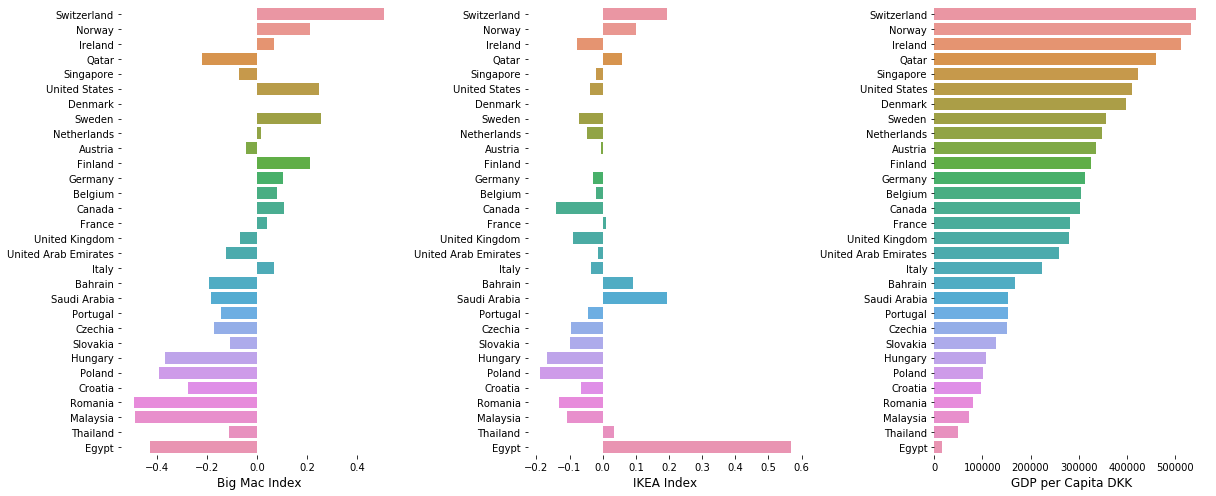

In [25]:
## 1) INDICES AND GDP:

df_BM = final_data2.sort_values('BigMac_index_DK', ascending=False)
df_IKEA = final_data2.sort_values('ikea_index_DK', ascending=False)
df_GDP = final_data2.sort_values('GDP_dkk', ascending=False)

f1,ax = plt.subplots(1,3, figsize=(17,7))
sns.barplot(x='BigMac_index_DK', y='Countries', data=df_GDP, ax=ax[0])
ax[0].set_xlabel('Big Mac Index', fontsize=12)
ax[0].set_ylabel('')
sns.barplot(x='ikea_index_DK', y='Countries', data=df_GDP, ax=ax[1]) 
ax[1].set_xlabel('IKEA Index', fontsize=12)
ax[1].set_ylabel('')
sns.barplot(x='GDP_dkk', y='Countries', data=df_GDP, ax=ax[2]) 
ax[2].set_xlabel('GDP per Capita DKK', fontsize=12)
ax[2].set_ylabel('')

sns.despine(bottom = True, left = True)

f1.tight_layout()


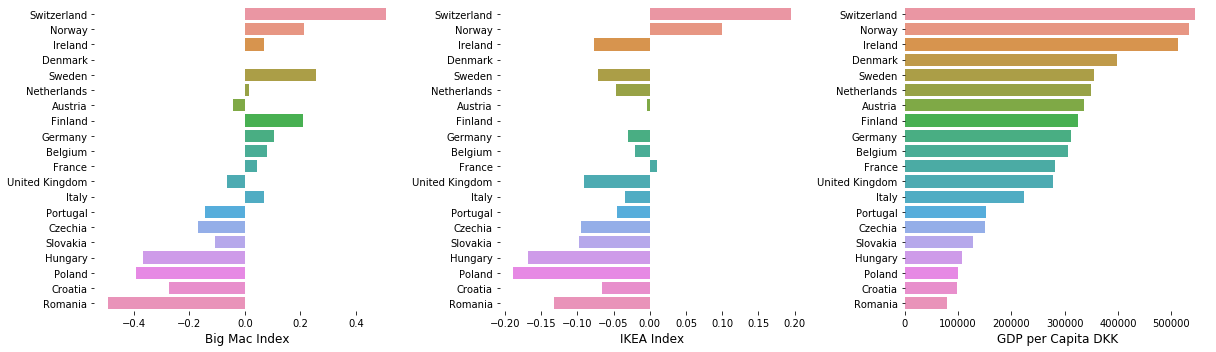

In [26]:
# NOW ONLY FOR EEA COUNTRIES:
final_data2eu = final_data2[final_data2['ESM']==1.0]

df_BM_eu = final_data2eu.sort_values('BigMac_index_DK', ascending=False)
df_IKEA_eu = final_data2eu.sort_values('ikea_index_DK', ascending=False)
df_GDP_eu = final_data2eu.sort_values('GDP_dkk', ascending=False)

rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
     }
plt.rcParams.update(rc)
f1eu,ax = plt.subplots(1,3, figsize=(17,5))
sns.barplot(x='BigMac_index_DK', y='Countries', data=df_GDP_eu, ax=ax[0])

ax[0].set_xlabel('Big Mac Index', fontsize=12)
ax[0].set_ylabel('')

sns.barplot(x='ikea_index_DK', y='Countries', data=df_GDP_eu, ax=ax[1]) 
ax[1].set_xlabel('IKEA Index', fontsize=12)
ax[1].set_ylabel('')
sns.barplot(x='GDP_dkk', y='Countries', data=df_GDP_eu, ax=ax[2]) 
ax[2].set_xlabel('GDP per Capita DKK', fontsize=12)
ax[2].set_ylabel('')

sns.despine(bottom = True, left = True)

f1eu.tight_layout()

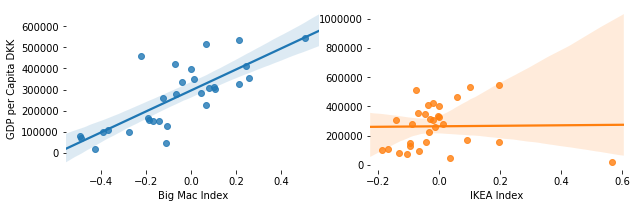

In [27]:
category_df = pd.concat([i for i in df_cat], ignore_index=True)
data2 = final_data2[final_data2['GDP_dkk']>0]

# RELATIONSHIP BETWEEN INDICES AND GDP 
f, ax = plt.subplots(1,2, figsize=(10, 3))
sns.regplot('BigMac_index_DK','GDP_dkk', data=data2, ax=ax[0])
ax[0].set_xlabel('Big Mac Index', fontsize=10)
ax[0].set_ylabel('GDP per Capita DKK', fontsize=10)
sns.regplot('ikea_index_DK','GDP_dkk', data=data2, ax=ax[1])
ax[1].set_xlabel('IKEA Index', fontsize=10)
ax[1].set_ylabel('')

sns.despine(bottom = True, left = True)

f1eu.tight_layout()

                                 OLS Regression Results                                
Dep. Variable:                GDP_dkk   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):             -0.016
Method:                 Least Squares   F-statistic:                             0.5333
Date:                Fri, 28 Aug 2020   Prob (F-statistic):                       0.471
Time:                        15:58:01   Log-Likelihood:                         -420.92
No. Observations:                  30   AIC:                                      843.8
Df Residuals:                      29   BIC:                                      845.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

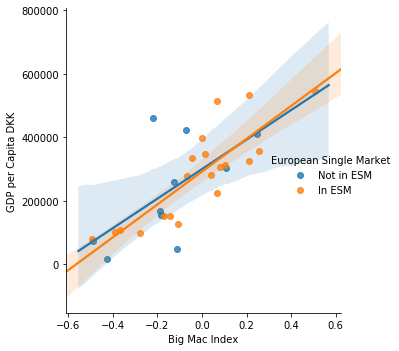

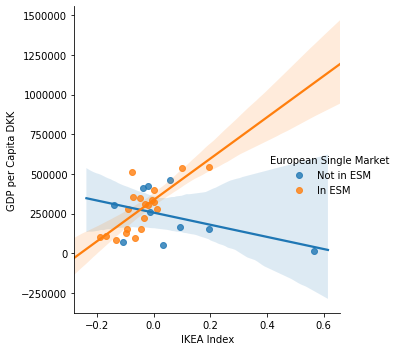

In [28]:
## 2) OLS REGRESSION:

# RELATIONSHIP BETWEEN BIGMAC INDEX AND GDP : 
model = sm.OLS(endog=data2['GDP_dkk'], exog=data2['BigMac_index_DK']).fit()
print(model.summary())
g=sns.lmplot('BigMac_index_DK','GDP_dkk', data=data2, hue='ESM')

new_title = 'European Single Market'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Not in ESM', 'In ESM']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    
ax = plt.gca()
ax.set_xlabel('Big Mac Index')
ax.set_ylabel('GDP per Capita DKK')

plt.savefig('reg1.png')

# RELATIONSHIP BETWEEN IKEA INDEX AND GDP : 
model = sm.OLS(endog=data2['GDP_dkk'], exog=data2['ikea_index_DK']).fit()
print(model.summary())
p= sns.lmplot('ikea_index_DK','GDP_dkk', data=data2, hue='ESM')


p._legend.set_title(new_title)

# replace labels
new_labels = ['Not in ESM', 'In ESM']
for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
    
ax1 = plt.gca()
ax1.set_xlabel('IKEA Index')
ax1.set_ylabel('GDP per Capita DKK')
plt.savefig('reg2.png')


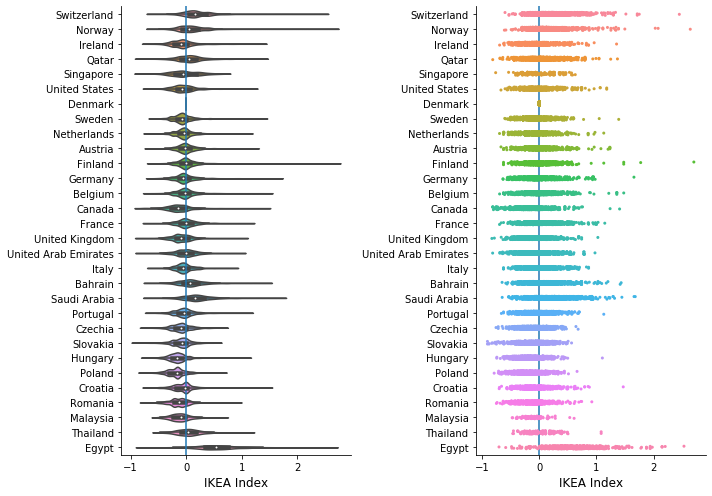

In [29]:
## 6) PLOTTING DISTRIBUTIONS OF PRODUCT-SPECIFIC IKEA INIDCES.

df_IKEA_dk = final_data_dk.sort_values('ikea_index_DK', ascending=False)
df_GDP_dk = final_data_dk.sort_values('GDP_dkk', ascending=False)

f3, ax = plt.subplots(1,2, figsize=(10,7))
sns.violinplot(x="ikea_index_DK", y="Countries", data=df_GDP_dk, size=5, ax=ax[0])
ax[0].set_xlabel('IKEA Index', fontsize=12)
ax[0].set_ylabel('')


sns.stripplot(x="ikea_index_DK", y="Countries", data=df_GDP_dk, size=3, ax=ax[1])
ax[1].set_xlabel('IKEA Index', fontsize=12)
ax[1].set_ylabel('')

ax[0].axvline(0) , ax[1].axvline(0)

sns.despine(bottom = False, right = True, top= True, left = False)

f3.tight_layout()

####   COMPARISONS FOR PRODUCT : KLÄMTARE   

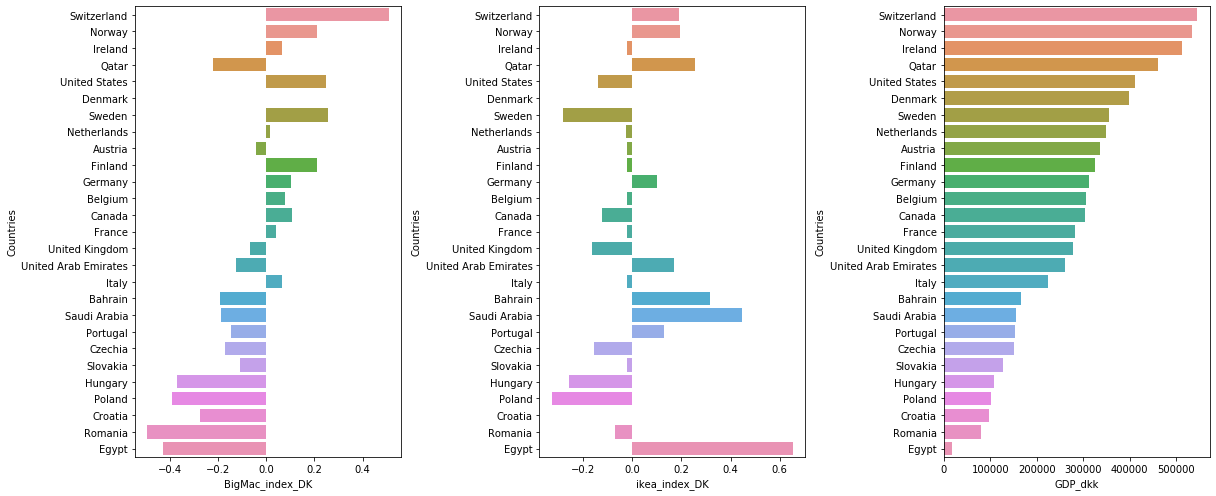

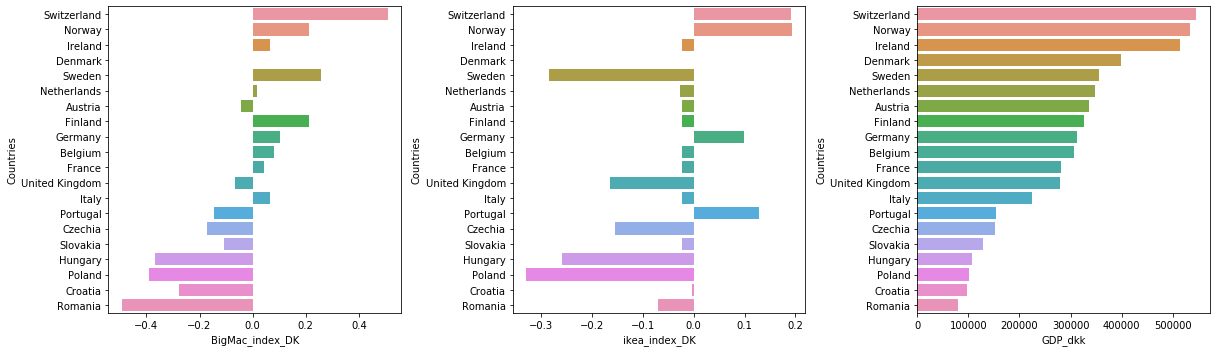

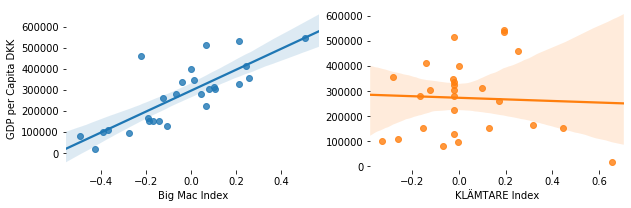

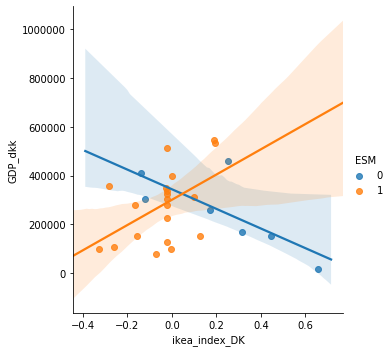

In [30]:
final_data_box = final_data_dk[final_data_dk['Product_Code']==70292364]

# Plot data for the index worldwide:
df_GDP_box = final_data_box.sort_values('GDP_dkk', ascending=False)

f1,ax = plt.subplots(1,3, figsize=(17,7))
sns.barplot(x='BigMac_index_DK', y='Countries', data=df_GDP_box, ax=ax[0]) 
sns.barplot(x='ikea_index_DK', y='Countries', data=df_GDP_box, ax=ax[1]) 
sns.barplot(x='GDP_dkk', y='Countries', data=df_GDP_box, ax=ax[2]) 
f1.tight_layout()

# Plot at European level:

final_data_box_eu = final_data_box[final_data_box['ESM']==1.0]
df_GDP_box_eu = final_data_box_eu.sort_values('GDP_dkk', ascending=False)

f1eu,ax = plt.subplots(1,3, figsize=(17,5))
sns.barplot(x='BigMac_index_DK', y='Countries', data=df_GDP_box_eu, ax=ax[0]) 
sns.barplot(x='ikea_index_DK', y='Countries', data=df_GDP_box_eu, ax=ax[1]) 
sns.barplot(x='GDP_dkk', y='Countries', data=df_GDP_box_eu, ax=ax[2]) 
f1eu.tight_layout()

# Regression KLÄMTARE Index:
f, ax = plt.subplots(1,2, figsize=(10, 3))
sns.regplot('BigMac_index_DK','GDP_dkk', data=final_data_box, ax=ax[0])
ax[0].set_xlabel('Big Mac Index', fontsize=10)
ax[0].set_ylabel('GDP per Capita DKK', fontsize=10)
sns.regplot('ikea_index_DK','GDP_dkk', data=final_data_box, ax=ax[1])
ax[1].set_xlabel('KLÄMTARE Index', fontsize=10)
ax[1].set_ylabel('')
sns.despine(bottom = True, left = True)

# ESM Model
model = sm.OLS(endog=final_data_box['GDP_dkk'], exog=final_data_box['ikea_index_DK']).fit()
sns.lmplot('ikea_index_DK','GDP_dkk', data=final_data_box, hue='ESM')

##  WORKING WITH CATEGORIES  

In [31]:
category_df_1 = category_df[(category_df['Category']=='sofa')|(category_df['Category']=='storage')|(category_df['Category']=='linen')]
category_df_2 = category_df[(category_df['Category']=='rugs')|(category_df['Category']=='dinnerware')|(category_df['Category']=='cookware')]
category_df_3 = category_df[(category_df['Category']=='lamps')|(category_df['Category']=='tables')|(category_df['Category']=='beds')]


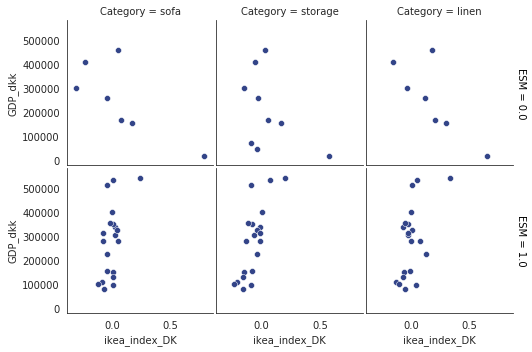

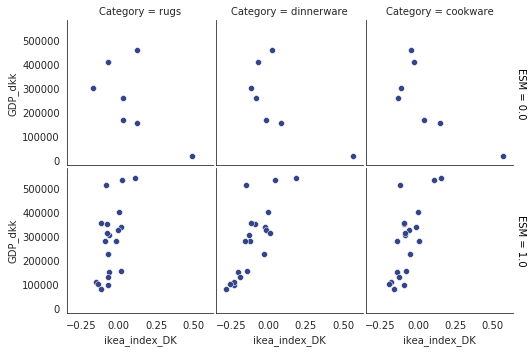

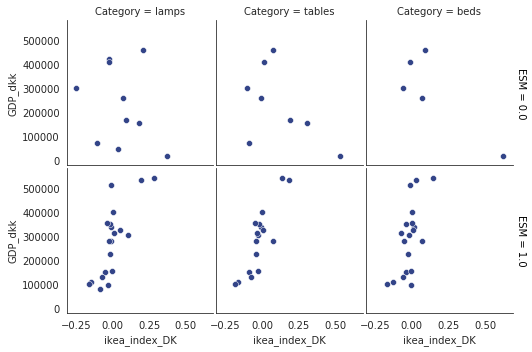

In [32]:
## SCATTERPLOT FOR EACH CATEGORY
with sns.axes_style("white"):
    g = sns.FacetGrid(category_df_1, row='ESM', col="Category", margin_titles=True, height=2.5)
g.map(plt.scatter, "ikea_index_DK", "GDP_dkk", color="#334488", edgecolor="white", lw=.5)
g.fig.subplots_adjust(wspace=.02, hspace=.02)

with sns.axes_style("white"):
    g = sns.FacetGrid(category_df_2, row='ESM', col="Category", margin_titles=True, height=2.5)
g.map(plt.scatter, "ikea_index_DK", "GDP_dkk", color="#334488", edgecolor="white", lw=.5)
g.fig.subplots_adjust(wspace=.02, hspace=.02)

with sns.axes_style("white"):
    g = sns.FacetGrid(category_df_3, row='ESM', col="Category", margin_titles=True, height=2.5)
g.map(plt.scatter, "ikea_index_DK", "GDP_dkk", color="#334488", edgecolor="white", lw=.5)
g.fig.subplots_adjust(wspace=.02, hspace=.02)

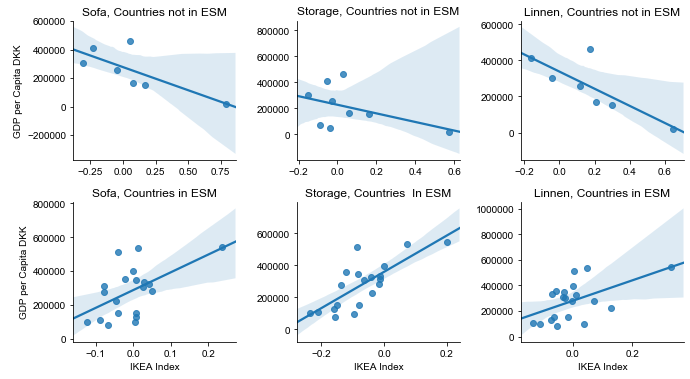

In [33]:
# REGRESSION FOR THE FIRST 3 CATEGORY
a = sns.lmplot('ikea_index_DK','GDP_dkk', category_df_1, row='ESM', col='Category',sharex=False,sharey=False, height=2.7, aspect=1.2)

a.axes[1,0].set_xlabel('IKEA Index')
a.axes[1,1].set_xlabel('IKEA Index')
a.axes[1,2].set_xlabel('IKEA Index')

a.axes[0,0].set_ylabel('GDP per Capita DKK')
a.axes[1,0].set_ylabel('GDP per Capita DKK')

a.axes[0,0].set_title('Sofa, Countries not in ESM')
a.axes[1,0].set_title('Sofa, Countries in ESM')

a.axes[0,1].set_title('Storage, Countries not in ESM')
a.axes[1,1].set_title('Storage, Countries  In ESM')

a.axes[0,2].set_title('Linnen, Countries not in ESM')
a.axes[1,2].set_title('Linnen, Countries in ESM')
sns.set_style("white")

a

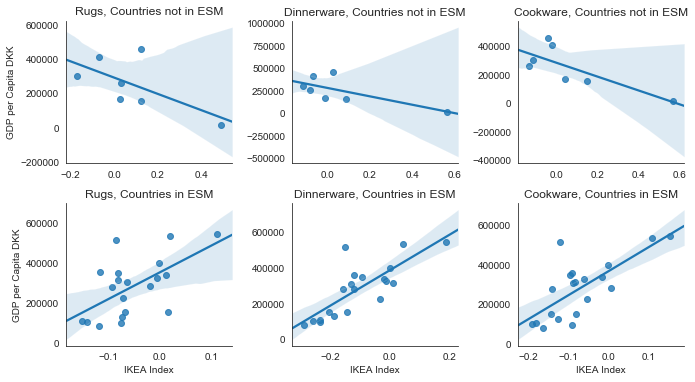

In [34]:
# REGRESSION FOR THE NEXT 3 CATEGORY
b=sns.lmplot('ikea_index_DK','GDP_dkk', category_df_2, row='ESM', col='Category',sharex=False,sharey=False, height=2.7, aspect=1.2)


b.axes[1,0].set_xlabel('IKEA Index')
b.axes[1,1].set_xlabel('IKEA Index')
b.axes[1,2].set_xlabel('IKEA Index')

b.axes[0,0].set_ylabel('GDP per Capita DKK')
b.axes[1,0].set_ylabel('GDP per Capita DKK')

b.axes[0,0].set_title('Rugs, Countries not in ESM')
b.axes[1,0].set_title('Rugs, Countries in ESM')

b.axes[0,1].set_title('Dinnerware, Countries not in ESM')
b.axes[1,1].set_title('Dinnerware, Countries in ESM')

b.axes[0,2].set_title('Cookware, Countries not in ESM')
b.axes[1,2].set_title('Cookware, Countries in ESM')
sns.set_style("white")

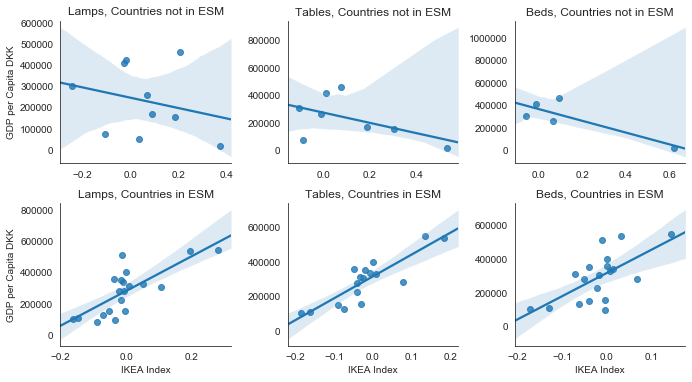

In [35]:
# REGRESSION FOR THE LAST 3 CATEGORY
c= sns.lmplot('ikea_index_DK','GDP_dkk', category_df_3, row='ESM', col='Category',sharex=False,sharey=False, height=2.7, aspect=1.2)

c.axes[1,0].set_xlabel('IKEA Index')
c.axes[1,1].set_xlabel('IKEA Index')
c.axes[1,2].set_xlabel('IKEA Index')

c.axes[0,0].set_ylabel('GDP per Capita DKK')
c.axes[1,0].set_ylabel('GDP per Capita DKK')

c.axes[0,0].set_title('Lamps, Countries not in ESM')
c.axes[1,0].set_title('Lamps, Countries in ESM')

c.axes[0,1].set_title('Tables, Countries not in ESM')
c.axes[1,1].set_title('Tables, Countries in ESM')

c.axes[0,2].set_title('Beds, Countries not in ESM')
c.axes[1,2].set_title('Beds, Countries in ESM')
sns.set_style("white")

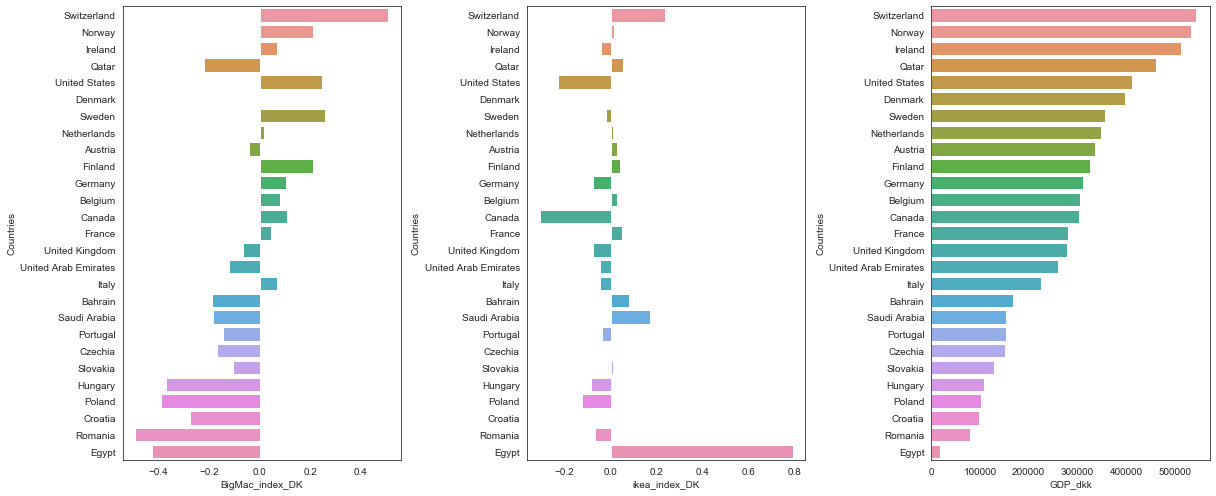

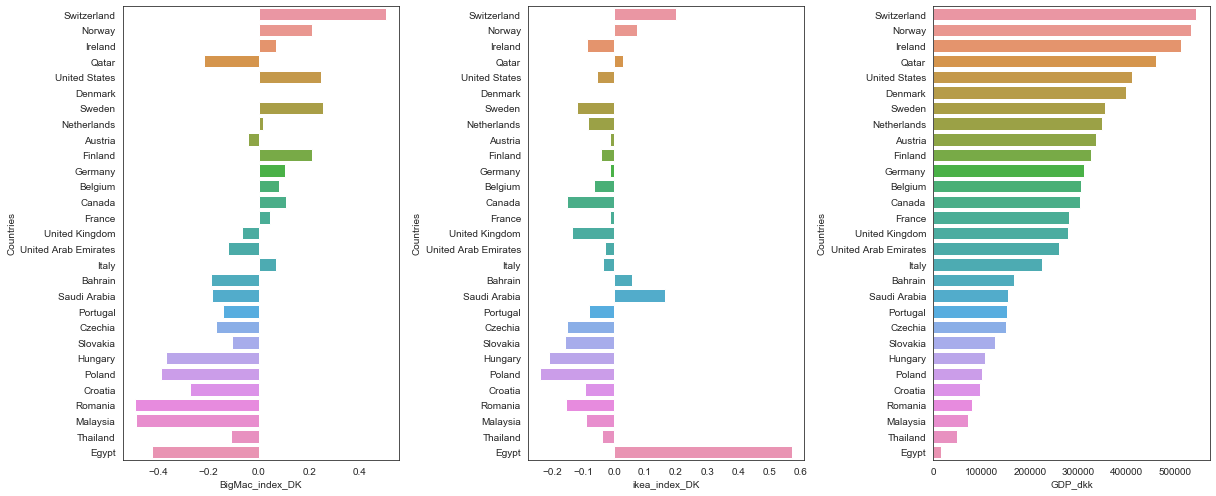

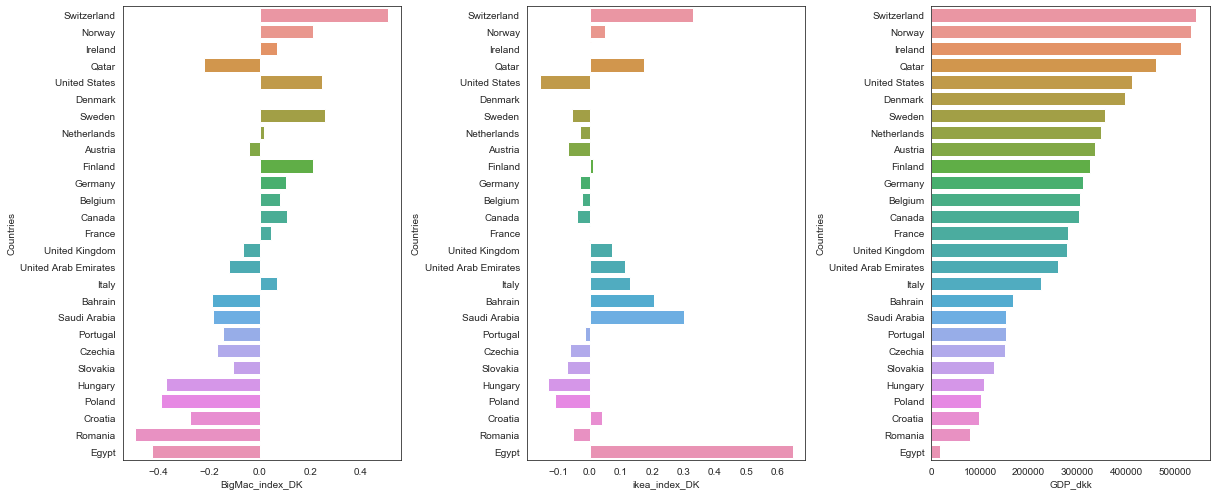

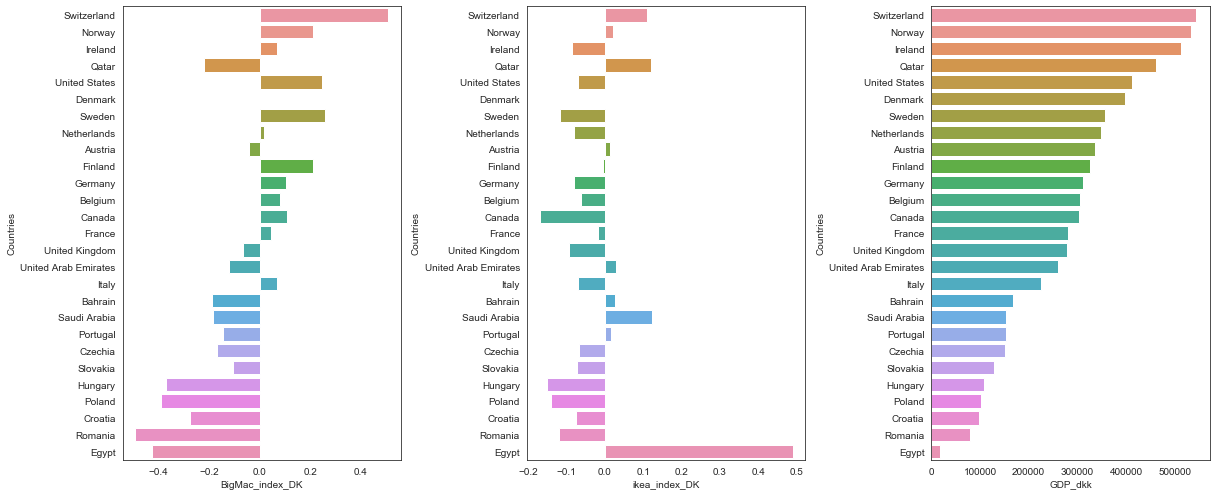

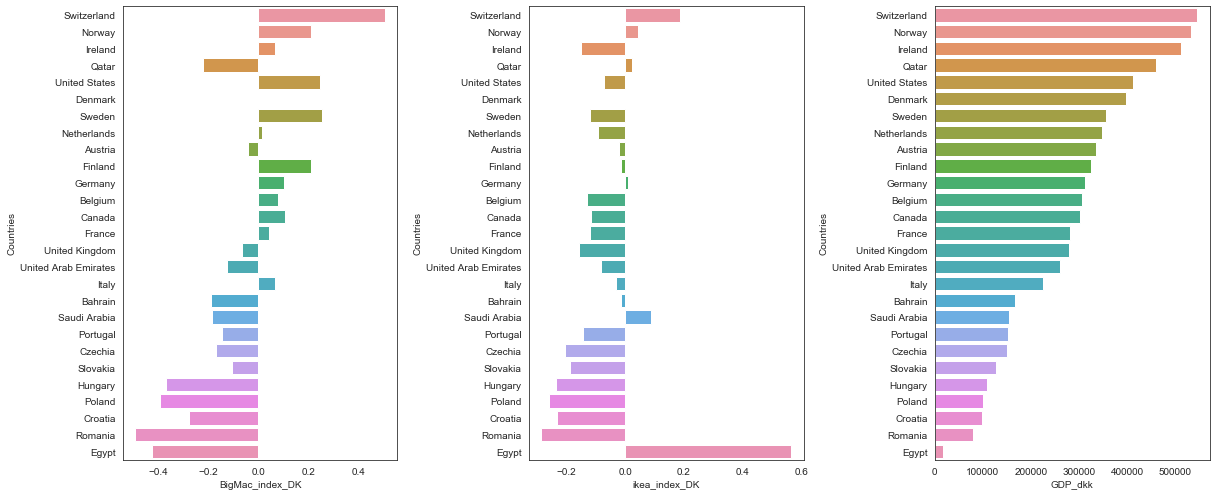

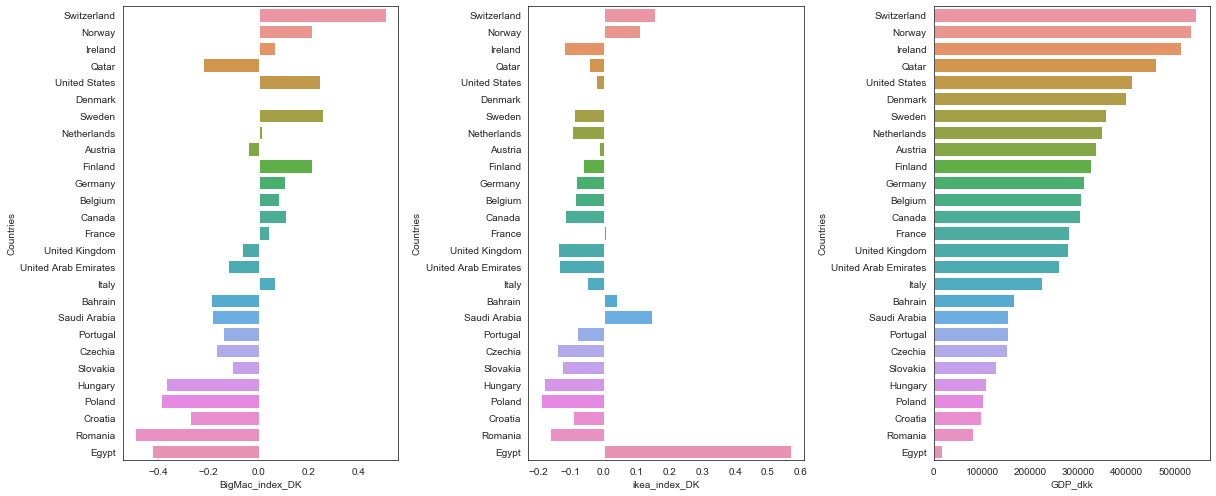

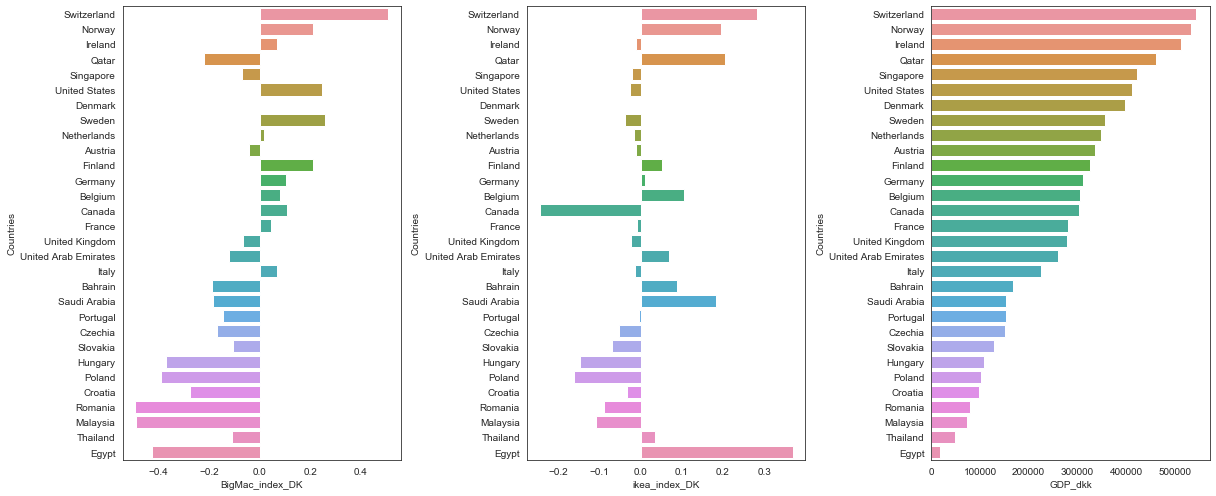

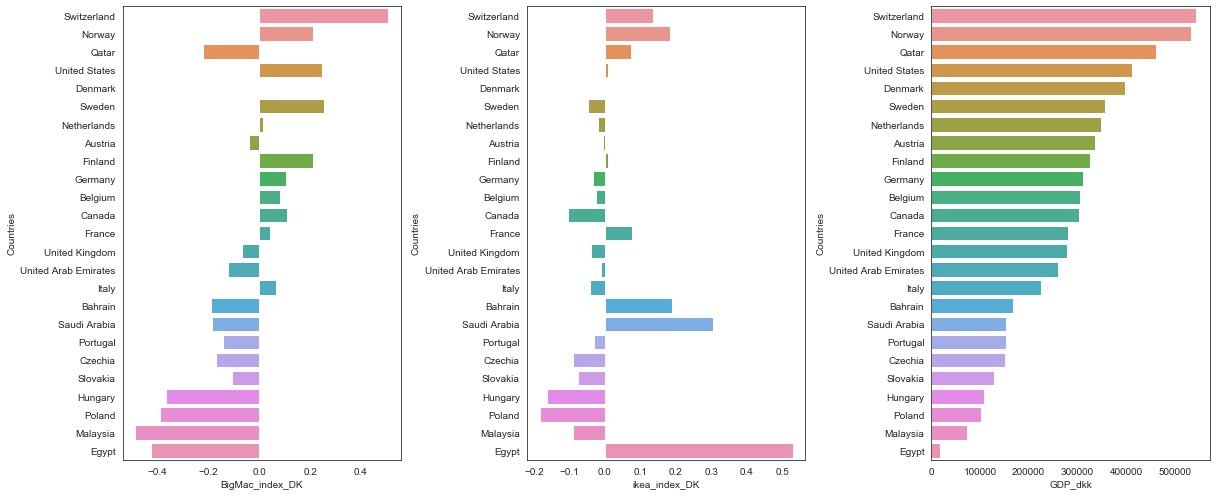

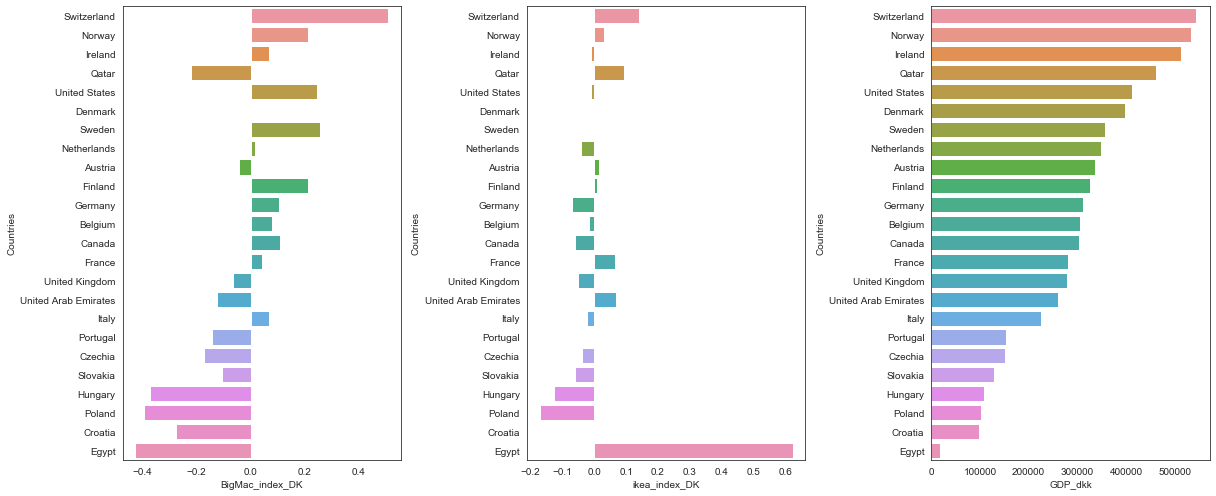

In [36]:
# Get dataframe for each category:
df_IKEA_sofa = df_cat[0].sort_values('GDP_dkk', ascending=False)
df_IKEA_storage = df_cat[1].sort_values('GDP_dkk', ascending=False)
df_IKEA_linen = df_cat[2].sort_values('GDP_dkk', ascending=False)
df_IKEA_rugs = df_cat[3].sort_values('GDP_dkk', ascending=False)
df_IKEA_dinner = df_cat[4].sort_values('GDP_dkk', ascending=False)
df_IKEA_cookware = df_cat[5].sort_values('GDP_dkk', ascending=False)
df_IKEA_lamps = df_cat[6].sort_values('GDP_dkk', ascending=False)
df_IKEA_tables = df_cat[7].sort_values('GDP_dkk', ascending=False)
df_IKEA_beds = df_cat[8].sort_values('GDP_dkk', ascending=False)

for i in [df_IKEA_sofa, df_IKEA_storage, df_IKEA_linen, df_IKEA_rugs, df_IKEA_dinner, \
          df_IKEA_cookware,df_IKEA_lamps, df_IKEA_tables, df_IKEA_beds]:
    f1,ax = plt.subplots(1,3, figsize=(17,7))
    sns.barplot(x='BigMac_index_DK', y='Countries', data=i, ax=ax[0]) 
    sns.barplot(x='ikea_index_DK', y='Countries', data=i, ax=ax[1]) 
    sns.barplot(x='GDP_dkk', y='Countries', data=i, ax=ax[2]) 
    f1.tight_layout()

###  MAPPING THE DATA  

In [37]:
# We obtain a base map of the world from the geopandas database
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
final_data2=final_data2.drop('Egypt')
# We add our data to the world dataframe, by matching them on the name of the country
indexdk = dict(final_data2['ikea_index_DK'])
gdpdk = dict(final_data2['GDP_dkk'])
bmindexdk = dict(final_data2['BigMac_index_DK'])
# There are variations in the countrynames, so a few manual changes had to be done
world = world[(world.pop_est>0) & (world.name!="Antarctica")& (world.name!="Egypt")]
world_countries = world['name'].tolist()
world_countries = ['Fiji','Tanzania','W. Sahara','Canada','United States','Kazakhstan','Uzbekistan','Papua New Guinea','Indonesia','Argentina','Chile','Dem. Rep. Congo','Somalia','Kenya','Sudan','Chad','Haiti','Dominican Rep.','Russia','Bahamas','Falkland Is.','Norway','Greenland','Fr. S. Antarctic Lands','Timor-Leste','South Africa','Lesotho','Mexico','Uruguay','Brazil','Bolivia','Peru','Colombia','Panama','Costa Rica','Nicaragua','Honduras','El Salvador','Guatemala','Belize','Venezuela','Guyana','Suriname','France','Ecuador','Puerto Rico','Jamaica','Cuba','Zimbabwe','Botswana','Namibia','Senegal','Mali','Mauritania','Benin','Niger','Nigeria','Cameroon','Togo','Ghana',"Côte d'Ivoire",'Guinea','Guinea-Bissau','Liberia','Sierra Leone','Burkina Faso','Central African Rep.','Congo','Gabon','Eq. Guinea','Zambia','Malawi','Mozambique','eSwatini','Angola','Burundi','Israel','Lebanon','Madagascar','Palestine','Gambia','Tunisia','Algeria','Jordan','United Arab Emirates','Qatar','Kuwait','Iraq','Oman','Vanuatu','Cambodia','Thailand','Laos','Myanmar','Vietnam','North Korea','South Korea','Mongolia','India','Bangladesh','Bhutan','Nepal','Pakistan','Afghanistan','Tajikistan','Kyrgyzstan','Turkmenistan','Iran','Syria','Armenia','Sweden','Belarus','Ukraine','Poland','Austria','Hungary','Moldova','Romania','Lithuania','Latvia','Estonia','Germany','Bulgaria','Greece','Turkey','Albania','Croatia','Switzerland','Luxembourg','Belgium','Netherlands','Portugal','Spain','Ireland','New Caledonia','Solomon Is.','New Zealand','Australia','Sri Lanka','China','Taiwan','Italy','Denmark','United Kingdom','Iceland','Azerbaijan','Georgia','Philippines','Malaysia','Brunei','Slovenia','Finland','Slovakia','Czechia','Eritrea','Japan','Paraguay','Yemen','Saudi Arabia','N. Cyprus','Cyprus','Morocco','Libya','Ethiopia','Djibouti','Somaliland','Uganda','Rwanda','Bosnia and Herz.','Macedonia','Serbia','Montenegro','Kosovo','Trinidad and Tobago','S. Sudan']
index = []

for i in world_countries:
    if i in indexdk:
        index.append(indexdk[i])
    else:
            index.append(np.nan)
bm = []
for i in world_countries:
    if i in bmindexdk:
        bm.append(bmindexdk[i])
    else:
            bm.append(np.nan)
gdp = []
for i in world_countries:
    if i in gdpdk:
        gdp.append(gdpdk[i])
    else:
            gdp.append(np.nan)
world['index'] = index
world['GDP_DK'] = gdp
world['Big_Mac'] = bm

### Making the maps

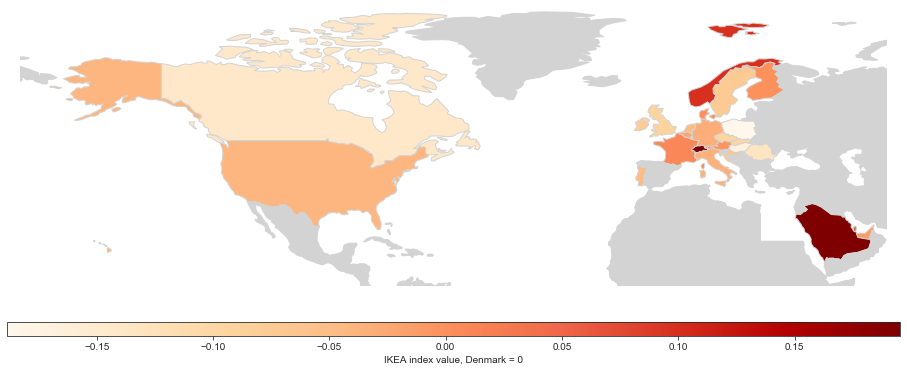

In [38]:
# the full map
fig, ax = plt.subplots(1, 1, figsize=(16,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
ax.set_xlim(-180, 60)
ax.set_ylim(10, 85)
ax.set_axis_off()
fig.add_axes(ax)
world.plot(column='index',
           ax=ax,
           legend=True, 
           legend_kwds={'label': "IKEA index value, Denmark = 0",
                        "orientation": "horizontal"},
           cax=cax, 
           missing_kwds={'color': 'lightgrey'}, 
           cmap='OrRd', edgecolor='lightgrey')
plt.savefig('ind_map.png')

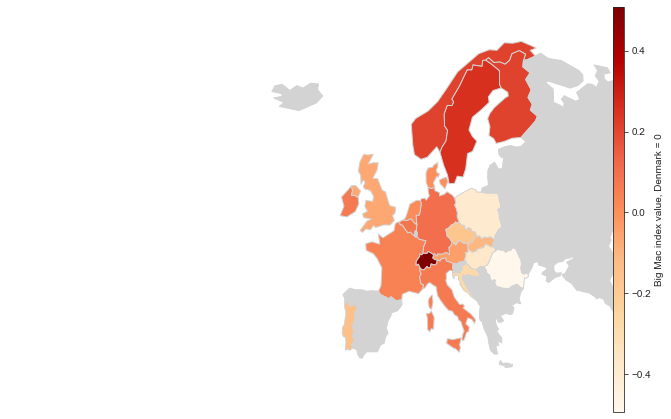

In [39]:
# Big Mac Index map
fig, ax = plt.subplots(1, 1, figsize=(16,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=-4)
ax.set_xlim(-80, 50)
ax.set_ylim(30, 75)
ax.set_axis_off()
fig.add_axes(ax)
base = world[world.continent == 'Europe']
base.plot(column='Big_Mac',
          ax=ax,
          legend=True,
          legend_kwds={'label': "Big Mac index value, Denmark = 0",
                        "orientation": "vertical"},
          cax=cax,
          missing_kwds={'color': 'lightgrey'},
          cmap='OrRd',
          edgecolor='lightgrey')



plt.savefig('big_mac_map_europe.png')

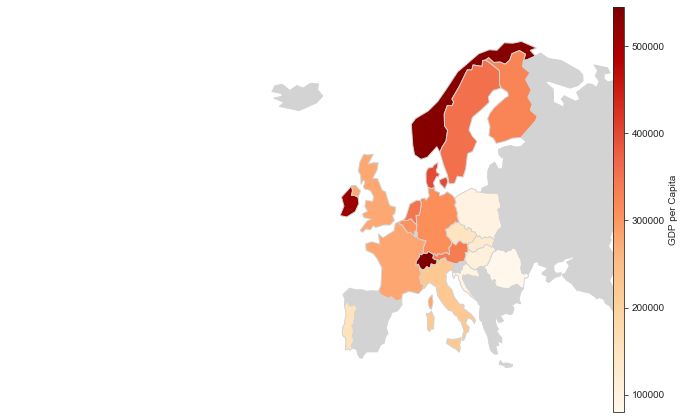

In [40]:
# GDP per capita Europe
fig, ax = plt.subplots(1, 1, figsize=(16,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=-4)
ax.set_xlim(-80, 50)
ax.set_ylim(30, 75)
ax.set_axis_off()
fig.add_axes(ax)
base = world[world.continent == 'Europe']
base.plot(column='GDP_DK',
          ax=ax,
          legend=True,
          legend_kwds={'label': "GDP per Capita",
                        "orientation": "vertical"},
          cax=cax,
          missing_kwds={'color': 'lightgrey'},
          cmap='OrRd', edgecolor='lightgrey')
plt.savefig('gdpc_map_europe.png')

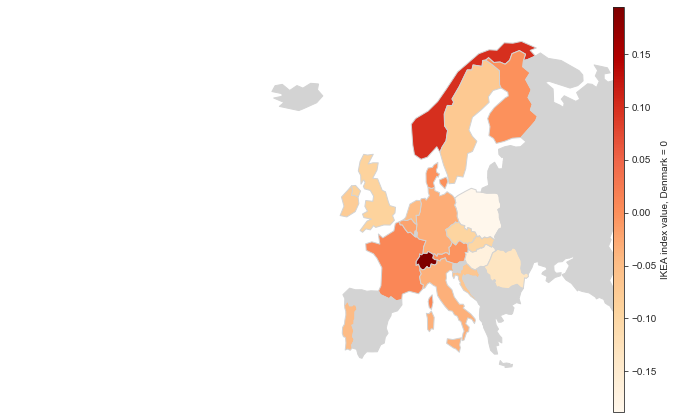

In [41]:
# IKEA Index Europe
fig, ax = plt.subplots(1, 1, figsize=(16,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=-4)
ax.set_xlim(-80, 50)
ax.set_ylim(30, 75)
ax.set_axis_off()
fig.add_axes(ax)
base = world[world.continent == 'Europe']
base.plot(column='index',
          ax=ax,
          legend=True,
          legend_kwds={'label': "IKEA index value, Denmark = 0",
                        "orientation": "vertical"},
          cax=cax,
          missing_kwds={'color': 'lightgrey'},
          cmap='OrRd', edgecolor='lightgrey')
plt.savefig('ind_map_europe.png')

### PURCHASING POWER PARITY CALCULATION

In [42]:
# Select only products that are available in Denmark:
final_data_justus = final_data[final_data['Countries']=='United States']
Product_Codesus = final_data_justus['Product_Code'].tolist()
final_data_us = final_data[final_data['Product_Code'].isin(Product_Codesus)]

# Delete countries with very few products <10:
df_temp_1 =  pd.DataFrame(final_data_us.Countries.value_counts()>10).reset_index()
df_temp_1.columns = ['Countries','index']
df_temp_2 = pd.merge(final_data_us, df_temp_1, on='Countries', how='left')
final_data_us = df_temp_2[df_temp_2['index']==True]

list_ikea_us=[]
# #Make a copy of final_data:
    
for product in final_data_us['Product_Code']:    
    #Narrow dataset for that product code:
    data_i = final_data_us.loc[final_data_us['Product_Code']==product].reset_index()
    # Obtain ikea_Denmark for that product:
    ikea_us = data_i.loc[data_i['Countries']=='United States'].ikea_local.tolist()[0] 
    list_ikea_us.append(ikea_us)
    
final_data_us['ikea_us'] = list_ikea_us
final_data_us['ikea_ppp_us'] = final_data_us['ikea_local']/final_data_us['ikea_us']

/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
ppp_us = final_data_us.groupby('Countries').mean()
ppp_us['Countries'] = ppp_us.index
ppp_us
# Imported data ICP 2017 from the World Bank: https://databank.worldbank.org/source/icp-2017#
# Set Countries: All
# Set Classification: PPPs (US$=1)
# Set Series: 1105000
# Set Time: 2017
ppp_data = pd.read_csv('ppp-data.csv')
ppp_data=ppp_data.rename(columns = {'Country Name':'Country'})
ppp_us=ppp_us.rename(columns = {'Countries':'Country'})
ppp = pd.merge(ppp_us, ppp_data, on='Country', how='left')
ppp=ppp.rename(columns = {'2017 [YR2017]':'ppp'})
ppp1 = ppp.dropna()
ppp1['ppp']=ppp1['ppp'].astype(float)

/Users/rasmusjuuljorgensen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [44]:
ppp_reg = sm.OLS(endog=ppp1['ppp'],exog=ppp1['ikea_ppp_us']).fit()
print(summary_col([ppp_reg],stars=True,float_format='%0.2f').as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lc}
\hline
              &   ppp    \\
\midrule
ikea\_ppp\_us & 0.79***  \\
              & (0.00)   \\
\hline
\end{tabular}
\end{center}
\end{table}


### Regression 

In [45]:
data2['indexesm'] = data2['ikea_index_DK']*data2['ESM']

In [46]:
# Turning GDP into GDP in Millions of currency unit
df_IKEA_sofa['gdp_m'] = df_IKEA_sofa['GDP_dkk']/1000000
df_IKEA_sofa['indexesm'] = df_IKEA_sofa['ikea_index_DK']*df_IKEA_sofa['ESM']

df_IKEA_storage['gdp_m'] = df_IKEA_storage['GDP_dkk']/1000000
df_IKEA_storage['indexesm'] = df_IKEA_storage['ikea_index_DK']*df_IKEA_storage['ESM']

df_IKEA_linen['gdp_m'] = df_IKEA_linen['GDP_dkk']/1000000
df_IKEA_linen['indexesm'] = df_IKEA_linen['ikea_index_DK']*df_IKEA_linen['ESM']

df_IKEA_rugs['gdp_m'] = df_IKEA_rugs['GDP_dkk']/1000000
df_IKEA_rugs['indexesm'] = df_IKEA_rugs['ikea_index_DK']*df_IKEA_rugs['ESM']

df_IKEA_dinner['gdp_m'] = df_IKEA_dinner['GDP_dkk']/1000000
df_IKEA_dinner['indexesm'] = df_IKEA_dinner['ikea_index_DK']*df_IKEA_dinner['ESM']

df_IKEA_cookware['gdp_m'] = df_IKEA_cookware['GDP_dkk']/1000000
df_IKEA_cookware['indexesm'] = df_IKEA_cookware['ikea_index_DK']*df_IKEA_cookware['ESM']

df_IKEA_lamps['gdp_m'] = df_IKEA_lamps['GDP_dkk']/1000000
df_IKEA_lamps['indexesm'] = df_IKEA_lamps['ikea_index_DK']*df_IKEA_lamps['ESM']

df_IKEA_tables['gdp_m'] = df_IKEA_tables['GDP_dkk']/1000000
df_IKEA_tables['indexesm'] = df_IKEA_tables['ikea_index_DK']*df_IKEA_tables['ESM']

df_IKEA_beds['gdp_m'] = df_IKEA_beds['GDP_dkk']/1000000
df_IKEA_beds['indexesm'] = df_IKEA_beds['ikea_index_DK']*df_IKEA_beds['ESM']

data2['gdp_m'] = data2['GDP_dkk']/1000000

In [47]:
#  Regression for each category and the index
reg0 = sm.OLS(df_IKEA_sofa['gdp_m'],df_IKEA_sofa[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg1 = sm.OLS(df_IKEA_storage['gdp_m'],df_IKEA_storage[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg2 = sm.OLS(df_IKEA_linen['gdp_m'],df_IKEA_linen[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg3 = sm.OLS(df_IKEA_rugs['gdp_m'],df_IKEA_rugs[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg4 = sm.OLS(df_IKEA_dinner['gdp_m'],df_IKEA_dinner[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg5 = sm.OLS(df_IKEA_cookware['gdp_m'],df_IKEA_cookware[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg6 = sm.OLS(df_IKEA_lamps['gdp_m'],df_IKEA_lamps[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg7 = sm.OLS(df_IKEA_tables['gdp_m'],df_IKEA_tables[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg8 = sm.OLS(df_IKEA_beds['gdp_m'],df_IKEA_beds[['ikea_index_DK', 'ESM', 'indexesm']]).fit()
reg9 = sm.OLS(data2['gdp_m'],data2[['ikea_index_DK', 'ESM', 'indexesm']]).fit()

In [48]:
print(summary_col([reg0, reg1, reg2, reg3, reg4],stars=True,float_format='%0.2f'))
print(summary_col([reg5, reg6, reg7, reg8, reg9],stars=True,float_format='%0.2f'))


              gdp_m I gdp_m II gdp_m III gdp_m IIII gdp_m IIIII
---------------------------------------------------------------
ikea_index_DK -0.15   -0.07    0.20      0.05       -0.15      
              (0.21)  (0.27)   (0.24)    (0.34)     (0.30)     
ESM           0.29*** 0.36***  0.28***   0.35***    0.38***    
              (0.04)  (0.05)   (0.04)    (0.06)     (0.05)     
indexesm      1.20*   1.20**   0.60      1.30       1.15**     
              (0.62)  (0.48)   (0.50)    (0.76)     (0.45)     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

              gdp_m I gdp_m II gdp_m III gdp_m IIII gdp_m IIIII
---------------------------------------------------------------
ikea_index_DK -0.16   0.21     0.20      0.12       0.01       
              (0.29)  (0.34)   (0.26)    (0.30)     (0.30)     
ESM           0.37*** 0.28***  0.31***   0.32***    0.34***    
              (0.05)  (0.04)   (0.04)    (0.05)     (0.05)     
indexesm      1.37**  0.90     1.06*     1.